In [1]:
import tensorflow as tf
import numpy as np
import os
import sys
import skimage
import pylab as plt
from importlib import reload
from datetime import datetime

sys.path.insert(0, '../src')
import deepleeo.dataset.data_augment as dtaug
import deepleeo.dataset.utils as dsutils 
import deepleeo.utils.geofunctions as gf
import deepleeo.networks.model_builder as mb
# from deepleeo.networks import fcn8s

reload(dtaug)
reload(dsutils)
# reload(fcn)
reload(mb)
reload(gf)

/home/raian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<module 'deepleeo.utils.geofunctions' from '../src/deepleeo/utils/geofunctions.py'>

# Load input Dataset

In [2]:
# DATA_DIR = os.path.join(os.path.abspath(os.path.dirname("__file__")), '../', 'data_real', 'generated')
# DATASET_FILE = os.path.join(DATA_DIR, 'samples_dataset_bin.npz')
network = "fcn8s"
DATA_DIR = "/home/raian/doutorado/Dados/generated"
DATASET_FILE = os.path.join(DATA_DIR, 'dataset_286x286_2016.npz')#'dataset_1.npz')
#TODO: Put network name here in the path
# model_dir = os.path.join(DATA_DIR, 'tf_logs', "test_%s_%s" % (network, datetime.now().strftime('%d_%m_%Y-%H_%M_%S')))
model_dir = "/home/raian/doutorado/DeepLeEO/data_real/generated/tf_logs/test_debug"
# model_dir = os.path.join(DATA_DIR, 'tf_logs', 'test_fcn8s_24_10_2018-19_09_09')

In [3]:
# raster_path = os.path.join(DATA_DIR, "..", "Landsat8_225064_17072016_R6G5B4_clip.tif")
# raster_path = os.path.join(DATA_DIR, "mosaic_2016.tif")
raster_path = os.path.join(DATA_DIR, 'stacked_mosaic_2016_2017.tif')

In [4]:
dataset = np.load(DATASET_FILE)

print("Data Loaded:")
print("  -> Images: ", len(dataset["images"]))
print("  -> Labels: ", len(dataset["labels"]))
print("  -> Classes: ", len(dataset["classes"]))

print("Images shape: ", dataset["images"][0].shape, " - DType: ", dataset["images"][0].dtype)
print("Labels shape: ", dataset["labels"][0].shape, " - DType: ", dataset["labels"][0].dtype)
# print("UNIQUE LABELS: ", np.unique(dataset["labels"]))

Data Loaded:
  -> Images:  5000
  -> Labels:  5000
  -> Classes:  2
Images shape:  (286, 286, 5)  - DType:  float32
Labels shape:  (286, 286, 1)  - DType:  int32


In [ ]:
#plt.figure(figsize=(4,4))
#img_plt = skimage.img_as_float(dataset["images"][0])
#img_plt = dataset["images"][0]
#plt.imshow(img_plt)
#plt.axis('off')

# Perform Data Augmentation

In [ ]:
reload(dtaug)
angles = [90, 180, 270]
rotated_imgs = dtaug.rotate_images(dataset["images"], angles)
flipped_imgs = dtaug.flip_images(dataset["images"])

new_dataset = {}
new_dataset["images"] = np.concatenate((dataset["images"], rotated_imgs))
new_dataset["images"] = np.concatenate((new_dataset["images"], flipped_imgs))

rotated_lbls = dtaug.rotate_images(dataset["labels"], angles)
flipped_lbls = dtaug.flip_images(dataset["labels"])

new_dataset["labels"] = np.concatenate((dataset["labels"], rotated_lbls))
new_dataset["labels"] = np.concatenate((new_dataset["labels"], flipped_lbls)).astype(dtype=np.int32)

new_dataset["classes"] = dataset["classes"]

print("Data Augmentation Applied:")
print("  -> Images: ", new_dataset["images"].shape)
print("  -> Labels: ", new_dataset["labels"].shape)

#print("  -> Unique Images: ", np.unique(new_dataset["images"]))
# print("  -> Unique Labels: ", np.unique(new_dataset["labels"]))

# Split dataset between train, test and validation data

In [ ]:
train_images, test_images, valid_images, train_labels, test_labels, valid_labels = dsutils.split_dataset(dataset)

print("Splitted dataset:")
print("  -> Train images: ", train_images.shape)
print("  -> Test images: ", test_images.shape)
print("  -> Validation images: ", valid_images.shape)
print("  -> Train Labels: ", train_labels.shape)
print("  -> Test Labels: ", test_labels.shape)
print("  -> Validation Labels: ", valid_labels.shape)

# print("  -> UNIQUE TRAIN LABELS: ", np.unique(train_labels), " - Type: ", train_labels.dtype)
# print("  -> UNIQUE TEST LABELS: ", np.unique(test_labels), " - Type: ", test_labels.dtype)
# print("  -> UNIQUE VALIDATION LABELS: ", np.unique(valid_labels))

# Train the Network

In [5]:
params = {
    "epochs": 2,
    "batch_size": 200,
    "learning_rate": 0.0001,
    "class_names": dataset["classes"],
    "multi_gpu": False
}

In [ ]:
# reload(fcn)
reload(mb)

model = mb.ModelBuilder(network)
model.train(train_images, test_images, train_labels, test_labels, params, model_dir)

In [ ]:
#fcn.fcn_evaluate(valid_images, valid_labels,)

In [12]:
#TODO: Verificar aqui. Seria necessário inverter x e y?
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

def generate_sequential_chips(img_array, chip_size=286):
    x_size, y_size, nbands = img_array.shape
    
    struct = {"chips":[], "coords":[]}
    for x_start in range(0, x_size, chip_size):
        x_end = x_start + chip_size
        
        if x_end > x_size:
            x_end = x_size
            x_start = x_end - chip_size
        
        for y_start in range(0, y_size, chip_size):
            y_end = y_start + chip_size
            
            if y_end > y_size:
                y_end = y_size
                y_start = y_end - chip_size
                
            chip_array = img_array[x_start:x_end, y_start:y_end, :]
            
            struct["chips"].append(chip_array)
            struct["coords"].append({"x_start": x_start, "x_end": x_end, "y_start": y_start, "y_end": y_end})
        
    return struct

In [41]:
import deepleeo.dataset.preprocessor as prep
import dataset.sequencialchips as seqchips

reload(gf)
reload(prep)
reload(seqchips)
#raster_array = gf.load_image(raster_path, 0)
#print(raster_path)

preproc = prep.Preprocessor(raster_path, no_data=-9999)
raster_array = preproc.standardize_image()
chips = seqchips.generate_sequential_chips(raster_array, chip_size=286)#, overlap=(93, 93))

Raster size: ( 11533 ,  13586 ,  10 )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


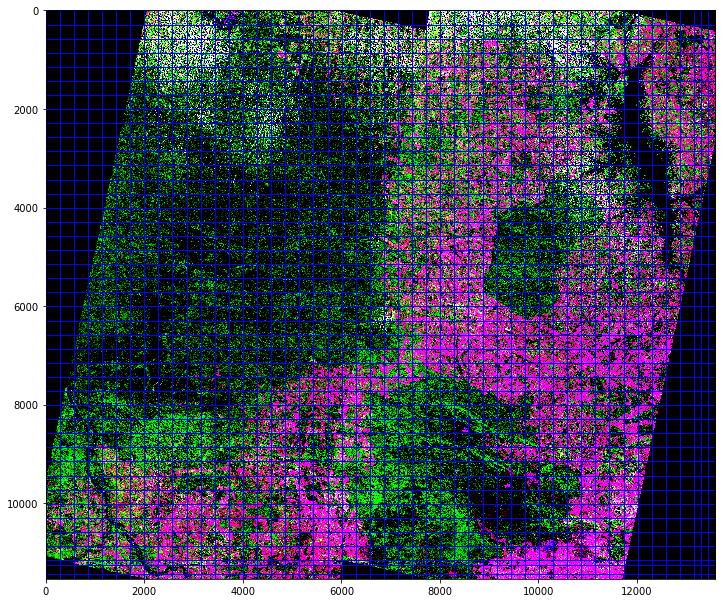

In [42]:
# Create figure and axes
import matplotlib.patches as patches
#TODO: Transform this in a function
fig,ax = plt.subplots(1, figsize=(12, 12))

# Display the image
ax.imshow(raster_array[:,:,[8, 7, 6]])

for coord in chips["coords"]:
    width = coord["y_end"] - coord["y_start"]
    height = coord["x_end"] - coord["x_start"]
    rect = patches.Rectangle((coord["y_start"], coord["x_start"]), width, height, edgecolor="blue", facecolor="none")
    ax.add_patch(rect)

In [29]:
reload(mb)

trained_model = "/home/raian/doutorado/Dados/generated/tf_logs/test_fcn8s_24_10_2018-19_09_09"

model = mb.ModelBuilder(network)
predictions = model.predict(chips["chips"], params=params, model_dir=trained_model)
out_pred = chips.copy()
out_pred["chips"] = predictions.copy()

{'x_start': 0, 'y_end': 286, 'x_end': 286, 'y_start': 0}
{'x_start': 286, 'y_end': 286, 'x_end': 572, 'y_start': 0}
{'x_start': 572, 'y_end': 286, 'x_end': 858, 'y_start': 0}
{'x_start': 858, 'y_end': 286, 'x_end': 1144, 'y_start': 0}
{'x_start': 1144, 'y_end': 286, 'x_end': 1430, 'y_start': 0}
{'x_start': 1430, 'y_end': 286, 'x_end': 1716, 'y_start': 0}
{'x_start': 1716, 'y_end': 286, 'x_end': 2002, 'y_start': 0}
{'x_start': 2002, 'y_end': 286, 'x_end': 2288, 'y_start': 0}
{'x_start': 2288, 'y_end': 286, 'x_end': 2574, 'y_start': 0}
{'x_start': 2574, 'y_end': 286, 'x_end': 2860, 'y_start': 0}
{'x_start': 2860, 'y_end': 286, 'x_end': 3146, 'y_start': 0}
{'x_start': 3146, 'y_end': 286, 'x_end': 3432, 'y_start': 0}
{'x_start': 3432, 'y_end': 286, 'x_end': 3718, 'y_start': 0}
{'x_start': 3718, 'y_end': 286, 'x_end': 4004, 'y_start': 0}
{'x_start': 4004, 'y_end': 286, 'x_end': 4290, 'y_start': 0}
{'x_start': 4290, 'y_end': 286, 'x_end': 4576, 'y_start': 0}
{'x_start': 4576, 'y_end': 286, '

Classifying image with structure  (1968, 286, 286, 10) ...
Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/raian/doutorado/Dados/generated/tf_logs/test_fcn8s_24_10_2018-19_09_09/model.ckpt-10800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [30]:
def discretize_values(data, numberClass, startValue = 0):
    for clazz in range(startValue, (numberClass + 1) ):
        if clazz == startValue:
            classFilter = (data <= clazz + 0.5)
        elif  clazz == numberClass:
            classFilter = (data > clazz - 0.5)
        else:
            classFilter = np.logical_and(data > clazz - 0.5, data <= clazz + 0.5) 
        data[classFilter] = clazz

    return data.astype(np.uint8)

new_pred = []
for chip in out_pred["chips"]:
    new_pred.append(discretize_values(chip, 2, 0))
    
out_pred["chips"] = new_pred.copy()

In [31]:
import gdal
import osr

output_path = os.path.join(DATA_DIR, "prediction.tiff")

def write_prediction(output_path, base_raster, pred_struct, output_format="GTiff", dataType=gdal.GDT_UInt16):
    driver = gdal.GetDriverByName(output_format)
    base_ds = gdal.Open(base_raster)
    
    x_start, pixel_width, _, y_start, _, pixel_height = base_ds.GetGeoTransform()
    x_size = base_ds.RasterXSize
    y_size = base_ds.RasterYSize
    
    srs = osr.SpatialReference()
    srs.ImportFromWkt(base_ds.GetProjectionRef())
    
    out_ds = driver.Create(output_path, x_size, y_size, 1, dataType)
    out_ds.SetGeoTransform((x_start, pixel_width, 0, y_start, 0, pixel_height))
    out_ds.SetProjection(srs.ExportToWkt())
    out_band = out_ds.GetRasterBand(1)
    
    for idx in range(1, len(pred_struct["chips"])):
        chip = pred_struct["chips"][idx]
        chip = np.squeeze(chip)
        out_band.WriteArray(chip, pred_struct["coords"][idx]["y_start"], pred_struct["coords"][idx]["x_start"])
        
    out_band.FlushCache()
    
write_prediction(output_path, raster_path, out_pred)

[0 1]
MIN:  0
MAX:  1


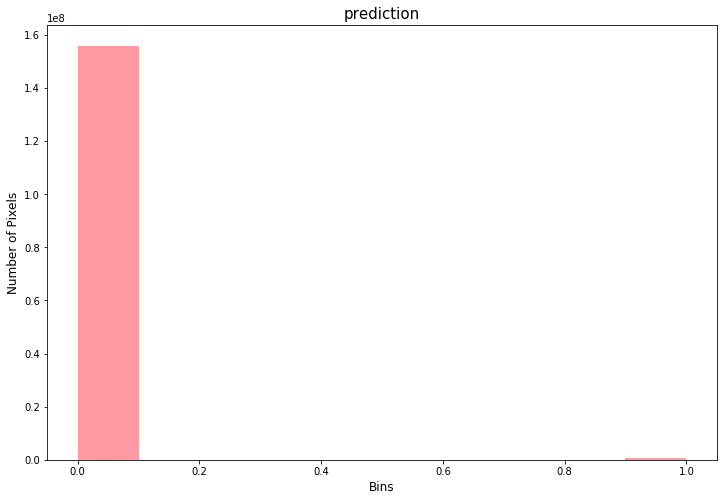

In [32]:
new_ds = gdal.Open(output_path)
rarr = new_ds.ReadAsArray()

print(np.unique(rarr))

import deepleeo.utils.visualization as vis
reload(vis)

print("MIN: ", np.min(rarr))
print("MAX: ", np.max(rarr))

vis.plot_image_histogram(rarr, title = "prediction")

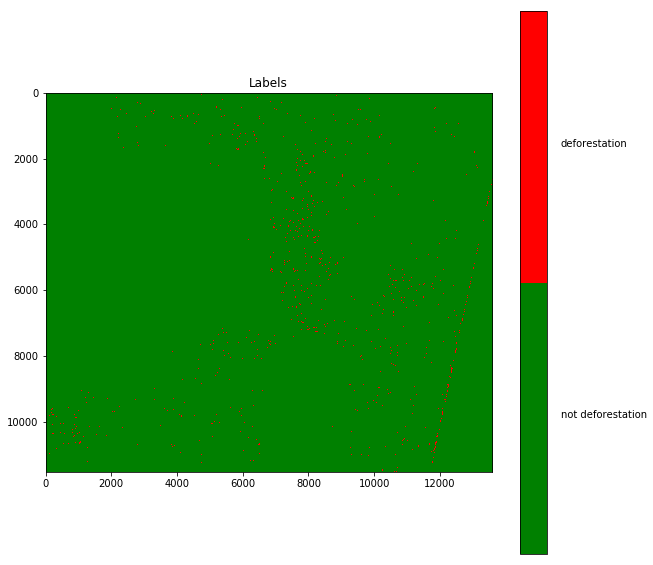

In [35]:
import deepleeo.utils.visualization as vis
reload(vis)
vis.plot_labels(rarr, ["not deforestation", "deforestation"], colors=["green", "red"])